# Springboard Time Series - 'Cowboy Cigarettes' Case Study - Tier 3

## Brief

You're working in the US federal government as a data scientist in the Health and Environment department. You've been tasked with determining whether sales for the oldest and most powerful producers of cigarettes in the country are increasing or declining. 

**Cowboy Cigarettes (TM, *est.* 1890)** is the US's longest-running cigarette manufacturer. Like many cigarette companies, however, they haven't always been that public about their sales and marketing data. The available post-war historical data runs for only 11 years after they resumed production in 1949; stopping in 1960 before resuming again in 1970. Your job is to use the 1949-1960 data to predict whether the manufacturer's cigarette sales actually increased, decreased, or stayed the same. You need to make a probable reconstruction of the sales record of the manufacturer - predicting the future, from the perspective of the past - to contribute to a full report on US public health in relation to major cigarette companies. 

The results of your analysis will be used as part of a major report relating public health and local economics, and will be combined with other studies executed by your colleagues to provide important government advice.  

-------------------------------
As ever, this notebook is **tiered**, meaning you can elect that tier that is right for your confidence and skill level. There are 3 tiers, with tier 1 being the easiest and tier 3 being the hardest.  

**1. Sourcing and loading** 
- Load relevant libraries 
- Load the data
- Explore the data

 
**2. Cleaning, transforming and visualizing**
- Dropping unwanted columns
- Nomenclature
- Type conversions
- Making a predictor variable `y` 
- Getting summary statistics for `y`
- Plotting `y`
  
  
**3. Modelling** 
- Decomposition
    - Trend
    - Seasonality
    - Noise
- Testing for stationarity with KPSS
- Making the data stationary
- The ARIMA Model
    - Make a function to find the MSE of a single ARIMA model
    - Make a function to evaluate the different ARIMA models with different p, d, and q values
- Visualize the results
- Application: Forecasting

**4. Evaluating and concluding** 
- What is our conclusion?
- Next steps
    

## 0. Preliminaries 

Time series data is just any data displaying how a single variable changes over time. It comes as a collection of metrics typically taken at regular intervals. Common examples of time series data include weekly sales data and daily stock prices. You can also easily acquire time series data from [Google Trends](https://trends.google.com/trends/?geo=US), which shows you how popular certain search terms are, measured in number of Google searches. 

## 1. Sourcing and Loading

### 1a. Load relevant libraries 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# tsa = time series analysis
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.arima.model import ARIMA      #original notebook listed old version: statsmodels.tsa.arima_model
from sklearn.metrics import mean_squared_error
from statsmodels.tools.print_version import show_versions

import warnings

In [2]:
show_versions(show_dirs=False)


INSTALLED VERSIONS
------------------
Python: 3.8.2.final.0
OS: Darwin 21.2.0 Darwin Kernel Version 21.2.0: Sun Nov 28 20:28:54 PST 2021; root:xnu-8019.61.5~1/RELEASE_X86_64 x86_64
byteorder: little
LC_ALL: None
LANG: en_US.UTF-8

statsmodels

Installed: 0.13.0

Required Dependencies

cython: Not installed
numpy: 1.21.2
scipy: 1.7.1
pandas: 1.3.4
    dateutil: 2.8.2
patsy: 0.5.2

Optional Dependencies

matplotlib: 3.4.3
cvxopt: Not installed
joblib: 1.1.0 

Developer Tools

IPython: 7.29.0
    jinja2: 2.11.3
sphinx: 4.2.0
    pygments: 2.10.0
pytest: Not installed
virtualenv: Not installed



INSTALLED VERSIONS
------------------
Python: 3.8.2.final.0
OS: Darwin 21.2.0 Darwin Kernel Version 21.2.0: Sun Nov 28 20:28:54 PST 2021; root:xnu-8019.61.5~1/RELEASE_X86_64 x86_64
byteorder: little
LC_ALL: None
LANG: en_US.UTF-8

statsmodels

Installed: 0.13.0 (/Users/Carsten/opt/anaconda3/envs/springboard/lib/python3.8/site-packages/statsmodels)

Required Dependencies

cython: Not installed
num

### 1b. Load the data
Call the variable `cigData`. 

In [3]:
cigData = pd.read_csv('CowboyCigsData.csv')

### 1c. Explore the data
We now need to check whether the data conduces to a time series style analysis.

In [4]:
cigData.head()

,Unnamed: 0,Time,#CigSales
0,0,1949-01,1000112
1,1,1949-02,1000118
2,2,1949-03,1000132
3,3,1949-04,1000129
4,4,1949-05,1000121


Over a million cigarettes sold in the month of January 1949. This certainly is a popular cigarette brand. 

Check out the columns feature of the data. How many columns are there? 

In [5]:
cigData.columns

Index(['Unnamed: 0', 'Time', '#CigSales'], dtype='object')

Let's check out the data types of our columns.

In [6]:
cigData.dtypes

Unnamed: 0     int64
Time          object
#CigSales      int64
dtype: object

Check whether there are any null values. 

In [7]:
cigData.isnull().sum()

Unnamed: 0    0
Time          0
#CigSales     0
dtype: int64

## 2. Cleaning, transforming and visualizing

### 2a. Dropping unwanted columns
We need to cut that `Unnamed: 0` column. Delete it here.

In [8]:
cigData.drop('Unnamed: 0',axis=1,inplace=True)
cigData.head()

,Time,#CigSales
0,1949-01,1000112
1,1949-02,1000118
2,1949-03,1000132
3,1949-04,1000129
4,1949-05,1000121


### 2b. Nomenclature

We can see that the `Time` column actually has the granularity of months. Change the name of that column to `Month`.

In [9]:
cigData.rename(columns={'Time':'Month'},inplace=True)

Call a head() to check this has worked. 

In [10]:
cigData.head()

,Month,#CigSales
0,1949-01,1000112
1,1949-02,1000118
2,1949-03,1000132
3,1949-04,1000129
4,1949-05,1000121


In [11]:
cigData['#CigSales']

0      1000112
1      1000118
2      1000132
3      1000129
4      1000121
        ...   
139    1000606
140    1000508
141    1000461
142    1000390
143    1000432
Name: #CigSales, Length: 144, dtype: int64

### 2c. Type conversions 

Now, do time series analysis on a Pandas dataframe is overkill, and is actually counter-productive. It's much more easy to carry out this type of analysis if we convert our data to a series first.

Notice that the `Month` field was an object. Let's type convert the `Month` column to a Python `datetime`, before making that the index.

In [12]:
# CB this doesn't work, all the values are converted to NaN:
cigDataSeries = pd.Series(data=cigData['#CigSales'],index=pd.to_datetime(cigData['Month']))
cigDataSeries.head()

# https://stackoverflow.com/questions/43708875/creating-time-series-from-pandas-dataframe
# The problem is that pd.Series() is trying to use the values specified in index
# to select values from the dataframe, but the date values in the dataframe are not present in the index.

Month
1949-01-01   NaN
1949-02-01   NaN
1949-03-01   NaN
1949-04-01   NaN
1949-05-01   NaN
Name: #CigSales, dtype: float64

In [13]:
# Instead make series, then set index:
cigDataSeries = cigData['#CigSales']
cigDataSeries.index = pd.to_datetime(cigData['Month'])
cigDataSeries.head()

Month
1949-01-01    1000112
1949-02-01    1000118
1949-03-01    1000132
1949-04-01    1000129
1949-05-01    1000121
Name: #CigSales, dtype: int64

In [14]:
# Or, set index on dataframe first, then extract single column
cigDataSeries = cigData.set_index(pd.to_datetime(cigData['Month']))['#CigSales']
cigDataSeries.head()

Month
1949-01-01    1000112
1949-02-01    1000118
1949-03-01    1000132
1949-04-01    1000129
1949-05-01    1000121
Name: #CigSales, dtype: int64

Perfect! 

### 2d. Making a predictor variable `y`

The data is now indexed by date, as time series data ought to be.

Since we want to predict the number of cigarette sales at Cowboy cigarettes, and `y` is typically used to signify a predictor variable, let's create a new variable called `y` and assign the indexed #Passenger column. 

In [15]:
# CB what does "assign the indexed #Passenger column" mean ???!!!
# I'll just do this instead.
y = cigDataSeries

Check the type of our new variable. 

In [16]:
type(y)

pandas.core.series.Series

### 2e. Getting summary statistics for `y`

Get the summary statistics of our data here. 

In [17]:
y.describe()

count    1.440000e+02
mean     1.000280e+06
std      1.199663e+02
min      1.000104e+06
25%      1.000180e+06
50%      1.000266e+06
75%      1.000360e+06
max      1.000622e+06
Name: #CigSales, dtype: float64

Try visualizing the data. A simple `matplotlib` plot should do the trick.  

### 2f. Plotting `y`

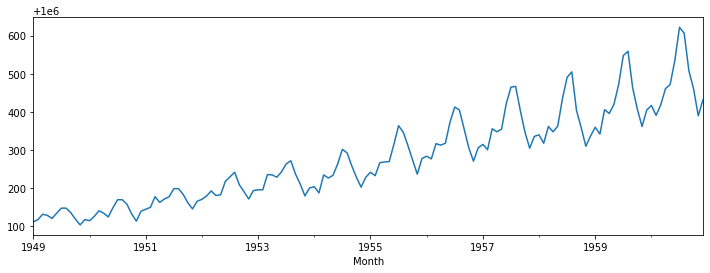

In [18]:
# well, pandas has plot support, so let's not do
#plt.plot(y);
#but instead:
y.plot(figsize=(12,4));

## 3. Modelling 
### 3a. Decomposition
What do you notice from the plot? Take at least `2` minutes to examine the plot, and write down everything you observe.  

All done?

We can see that, generally, there is a trend upwards in cigarette sales from at Cowboy Cigarettes. But there are also some striking - and perhaps unexpected - seasonal fluctuations. These seasonal fluctations come in a repeated pattern. Work out when these seasonal fluctuations are happening, and take 2 minutes to hypothesize on their cause here.

What does it mean to *decompose* time series data? It means breaking that data into 3 components: 

1. **Trend**: The overall direction that the data is travelling in (like upwards or downwards)
2. **Seasonality**: Cyclical patterns in the data 
3. **Noise**: The random variation in the data

We can treat these components differently, depending on the question and what's appropriate in the context. They can either be added together in an *additive* model, or multiplied together in a *multiplicative* model. 

Make a coffee, take `5` minutes and read [this article](https://medium.com/@sigmundojr/seasonality-in-python-additive-or-multiplicative-model-d4b9cf1f48a7) and think about whether our data would conduce to an additive or multiplicative model here. Write your conclusion down just here: 

----multiplicative---------------------------

All done? Well, just on the basis of the plot above, it seems our Cowboy Cigarettes data is actually multiplicative. 

That's because, as time progresses, the general trend seems to be increasing *at a rate that's also increasing*. We also see that the seasonal fluctuations (the peaks and troughs) get bigger and bigger as time progresses.

Now on the other hand, if the data were simply additive, we could expect the general trend to increase at a *steadily*, and a constant speed; and also for seasonal ups and downs not to increase or decrease in extent over time.

Happily, we can use the `decompose()` function to quantify the component parts described above in our data.

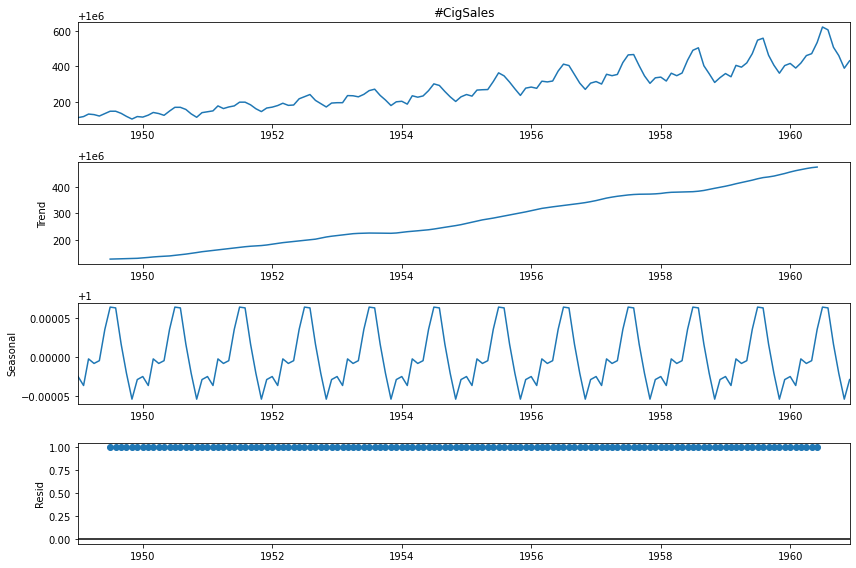

In [19]:
# https://www.statsmodels.org/dev/generated/statsmodels.tsa.seasonal.seasonal_decompose.html
decomposition = seasonal_decompose(y,model='multiplicative')

# Plot the original data, the trend, the seasonality, and the residuals 
plt.rc("figure", figsize=(12,8))
decomposition.plot();

### 3b. Testing for stationarity with KPSS
As you know, when doing time series analysis we always have to check for stationarity. Imprecisely, a time series dataset is stationary just if its statistical features don't change over time. A little more precisely, a stationary time series dataset will have constant mean, variance, and covariance.

There are many ways to test for stationarity, but one of the most common is the KPSS test. The Null hypothesis of this test is that the time series data in question is stationary; hence, if the *p*-value is less than the significance level (typically 0.05, but we decide) then we reject the Null and infer that the data is not stationary.

In [20]:
# https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.kpss.html
# Computes the Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test
# for the null hypothesis that x is level or trend stationary

#from statsmodels.tsa.stattools import kpss
# regression='c' tests whether vector is stationary about a constant
kpss_stat,p_value,lags,crit = kpss(y, regression='c', nlags='auto', store=False)
p_value

/Users/Carsten/opt/anaconda3/envs/springboard/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1998: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


0.01

Since our p-value is less than 0.05, we should reject the Null hypothesis and deduce the non-stationarity of our data. 

But our data need to be stationary! So we need to do some transforming.

In [21]:
# CB why does our data need to be stationary???

### 3c. Making the data stationary 
Let's recall what it looks like. 

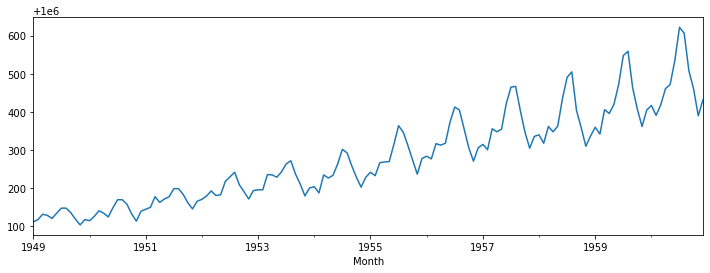

In [22]:
# "it" ?  Maybe it means the original data???
y.plot(figsize = (12,4));

In our plot, we can see that both the mean and the variance *increase as time progresses*. At the moment, our data has neither a constant mean, nor a constant variance (the covariance, however, seems constant). 

One ofte  used way of getting rid of changing variance is to take the natural log of all the values in our dataset. Let's do this now. 

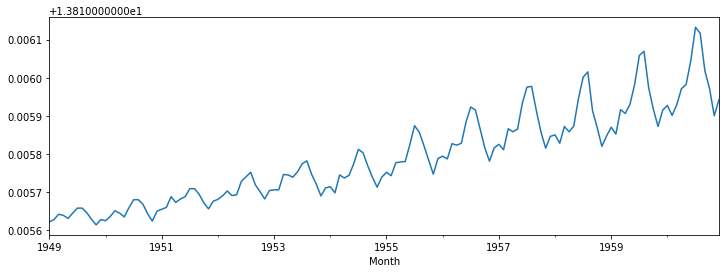

In [23]:
#no .log() method for pandas Series...
y_log = np.log(y)
y_log.plot(figsize = (12,4));


When you plot this, you can see how the variance in our data now remains contant over time.

In [24]:
# CB, actually, the relative variance is similar before and after transformation,
# and doesn't remain constant over time.

In [25]:
type(y)

pandas.core.series.Series

We now have a constant variance, but we also need a constant mean.

We can do this by *differencing* our data. We difference a time series dataset when we create a new time series comprising the difference between the values of our existing dataset.

Python is powerful, and we can use the `diff()` function to do this. You'll notice there's one less value than our existing dataset (since we're taking the difference between the existing values).

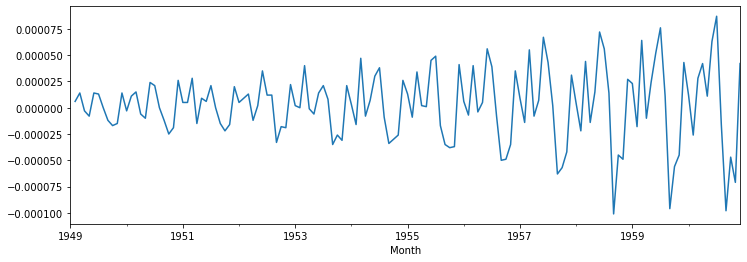

In [26]:
# https://numpy.org/doc/stable/reference/generated/numpy.diff.html
# y_log_diff = np.diff(y_log)
# actually, previous creates ndarray without index, and harder to plot

# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.diff.html
y_log_diff = y_log.diff()

y_log_diff.plot(figsize = (12,4));

In [27]:
# CB: I guess I should retest for stationarity ?
kpss_stat,p_value,lags,crit = kpss(y_log_diff, regression='c', nlags='auto', store=False)
p_value

ValueError: cannot convert float NaN to integer

In [28]:
# OK, let's drop the NaN
y_log_diff_trim = y_log_diff.dropna()
kpss_stat,p_value,lags,crit = kpss(y_log_diff_trim, regression='c', nlags='auto', store=False)
p_value

/Users/Carsten/opt/anaconda3/envs/springboard/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:2002: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


0.1

Our p-value is now greater than 0.05, so we can accept the null hypothesis that our data is stationary.

In [29]:
# CB what's not explained is that good ARIMA model needs to be stationary.  Since ARIMA implements a differencing parameter 'd',
# using a value of 'd' that makes the model stationary will lead to improved ARIMA model.  The first difference is d=1.

### 3d. The ARIMA model

Recall that ARIMA models are based around the idea that it's possible to predict the next value in a time series by using information about the most recent data points. It also assumes there will be some randomness in our data that can't ever be predicted.

We can find some good parameters for our model using the `sklearn` and `statsmodels` libraries, and in particular `mean_squared_error` and `ARIMA`. 

In [30]:
# CB: DataCamp was mostly on ARMA models, which work with differenced data.
# ARIMA models can handle on undifferenced data input, because also include a differencing parameter 'd'.

In [31]:
# Import mean_squared_error and ARIMA
#from sklearn.metrics import mean_squared_error
#from statsmodels.tsa.arima.model import ARIMA

#### 3di. Make a function to find the MSE of a single ARIMA model
Things get intricate here. Don't worry if you can't do this yourself and need to drop down a Tier. 

In [32]:
# CB: I started with Tier2 for this step
# Why does this example iteratively fit a model by incrementally adding each prediction point to train set?
# DataCamp ARIMA example did a single model fit, and used .plot_predict() to select full forecast range

In [33]:
# Make a function called evaluate_arima_model to find the MSE of a single ARIMA model

# https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima.model.ARIMA.html (0.13.1)
# https://www.statsmodels.org/v0.12.2/generated/statsmodels.tsa.arima_model.ARIMA.fit.html (this one includes disp=0)
# "disp (int, optional): If True, convergence information is printed"

def evaluate_arima_model(data, arima_order):
    # Needs to be an integer because it is later used as an index.
    # Use int()
    split=int(len(data) * 0.8) 
    # Make train and test variables, with 'train, test'
    train, test = data[0:split], data[split:len(data)]
    past=[x for x in train]     #CB apparently need to convert pandas Series to list
    # make predictions. Declare a variable with that name
    predictions = list()
    for i in range(len(test)):#timestep-wise comparison between test data and one-step prediction ARIMA model. 
        model = ARIMA(past, order=arima_order)
        model_fit = model.fit()     # older version supported model.fit(disp=0)
        future = model_fit.forecast()[0]      # CB: could instead use .forecast(steps=1)
        # Append() here
        predictions.append(future)
        past.append(test[i])
    # calculate out of sample error
    error = mean_squared_error(test, predictions)
    # Return the error
    return error

#### 3dii. Make a function to evaluate the different ARIMA models with different p, d, and q values

In [34]:
# Make a function called evaluate_models to evaluate different ARIMA models with several different p, d, and q values.
def evaluate_models(dataset, p_values, d_values, q_values):
    best_score, best_cfg = float("inf"), None
    # Iterate through p_values
    for p in p_values:
        # Iterate through d_values
        for d in d_values:
            # Iterate through q_values
            for q in q_values:
                # p, d, q iterator variables in that order
                order = (p,d,q)
                try:
                    # Make a variable called mse for the Mean squared error
                    print(order)     #CB added
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.12f' % (order,mse))
                except:
                    continue
    return print('Best ARIMA%s MSE=%.12f' % (best_cfg, best_score))

In [35]:
# Now, we choose a couple of values to try for each parameter.
p_values=[0,1,2]    #order of the autoregressive component
d_values=[0,1,2]    #which derivative (difference) to use
q_values=[0,1,2]    #order of the moving average component

In [36]:
# Finally, we can find the optimum ARIMA model for our data.
# Nb. this can take a while...!

#CB Tier2 notebook added warning suppressions, which would normally appear for every tested set of parameters.
#It would be nice to understand whether we _should_ ignore these warnings!
warnings.filterwarnings("ignore")
evaluate_models(y_log, p_values, d_values, q_values)
warnings.filterwarnings("default")

(0, 0, 0)
ARIMA(0, 0, 0) MSE=0.000000040266
(0, 0, 1)
ARIMA(0, 0, 1) MSE=0.000000040247
(0, 0, 2)
ARIMA(0, 0, 2) MSE=0.000000030872
(0, 1, 0)
ARIMA(0, 1, 0) MSE=0.000000002753
(0, 1, 1)
ARIMA(0, 1, 1) MSE=0.000000002448
(0, 1, 2)
ARIMA(0, 1, 2) MSE=0.000000002581
(0, 2, 0)
ARIMA(0, 2, 0) MSE=0.000000003800
(0, 2, 1)
ARIMA(0, 2, 1) MSE=0.000000003626
(0, 2, 2)
ARIMA(0, 2, 2) MSE=0.000000003325
(1, 0, 0)
ARIMA(1, 0, 0) MSE=0.000000002779
(1, 0, 1)
ARIMA(1, 0, 1) MSE=0.000000002427
(1, 0, 2)
ARIMA(1, 0, 2) MSE=0.000000002499
(1, 1, 0)
ARIMA(1, 1, 0) MSE=0.000000002502
(1, 1, 1)
ARIMA(1, 1, 1) MSE=0.000000002451
(1, 1, 2)
ARIMA(1, 1, 2) MSE=0.000000002321
(1, 2, 0)
ARIMA(1, 2, 0) MSE=0.000000003776
(1, 2, 1)
ARIMA(1, 2, 1) MSE=0.000000003378
(1, 2, 2)
ARIMA(1, 2, 2) MSE=0.000000003323
(2, 0, 0)
ARIMA(2, 0, 0) MSE=0.000000002455
(2, 0, 1)
ARIMA(2, 0, 1) MSE=0.000000002454
(2, 0, 2)
ARIMA(2, 0, 2) MSE=0.000000040082
(2, 1, 0)
ARIMA(2, 1, 0) MSE=0.000000002423
(2, 1, 1)
ARIMA(2, 1, 1) MSE=0.0

So the best p,d, q, parameters for our ARIMA model are 2, 1, 1 respectively. Now we know this, we can build the model.

In [37]:
# CB actually, let me test higher autoregression lags, since there's strong seasonality,
# and there are 12 values per year.
p_values=[2,3,4,5,6,7,8,9,10,11,12,13,14,15]    #order of the autoregressive component
d_values=[1]    #which derivative (difference) to use. Previous test showed that d>0 is important (do some differencing).
q_values=[1]    #order of the moving average component. Previous test hinted q>1 worse than q=1.

In [38]:
warnings.filterwarnings("ignore")
evaluate_models(y_log, p_values, d_values, q_values)
warnings.filterwarnings("default")

(2, 1, 1)
ARIMA(2, 1, 1) MSE=0.000000002227
(3, 1, 1)
ARIMA(3, 1, 1) MSE=0.000000002369
(4, 1, 1)
ARIMA(4, 1, 1) MSE=0.000000002206
(5, 1, 1)
ARIMA(5, 1, 1) MSE=0.000000002252
(6, 1, 1)
ARIMA(6, 1, 1) MSE=0.000000002238
(7, 1, 1)
ARIMA(7, 1, 1) MSE=0.000000002308
(8, 1, 1)
ARIMA(8, 1, 1) MSE=0.000000001823
(9, 1, 1)
ARIMA(9, 1, 1) MSE=0.000000001765
(10, 1, 1)
ARIMA(10, 1, 1) MSE=0.000000001142
(11, 1, 1)
ARIMA(11, 1, 1) MSE=0.000000001797
(12, 1, 1)
ARIMA(12, 1, 1) MSE=0.000000002714
(13, 1, 1)
ARIMA(13, 1, 1) MSE=0.000000002982
(14, 1, 1)
ARIMA(14, 1, 1) MSE=0.000000002976
(15, 1, 1)
ARIMA(15, 1, 1) MSE=0.000000002962
Best ARIMA(10, 1, 1) MSE=0.000000001142


In [39]:
# CB in addition to testing the ARIMA(order=(2,1,1)) model, we should evaluate the ARIMA(order=(10,1,1)) model

In [40]:
p=2
d=1
q=1
model = ARIMA(y_log, order=(p,d,q))
model_fit = model.fit()
forecast = model_fit.forecast(24)

/Users/Carsten/opt/anaconda3/envs/springboard/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/Carsten/opt/anaconda3/envs/springboard/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/Carsten/opt/anaconda3/envs/springboard/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


We can take a look at a summary of the model this library has built around our data.

In [41]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              #CigSales   No. Observations:                  144
Model:                 ARIMA(2, 1, 1)   Log Likelihood                1285.631
Date:                Wed, 12 Jan 2022   AIC                          -2563.263
Time:                        18:15:05   BIC                          -2551.411
Sample:                    01-01-1949   HQIC                         -2558.447
                         - 12-01-1960                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0575    1.1e-19   9.59e+18      0.000       1.057       1.057
ar.L2         -0.4391   6.75e-19  -6.51e+17      0.000      -0.439      -0.439
ma.L1         -0.7080   3.02e-20  -2.35e+19      0.000      -0.708      -0.708
sigma2      8.444e-10   2.83e-10      2.983      0.003     2.9e-10     1.4e-09
===================================================================================
Ljung-Box (L1) (Q):                   0.64   Jarque-Bera (JB):                 0.64
Prob(Q):                              0.42   Prob(JB):                         0.73
Heteroskedasticity (H):               7.96   Skew:                             0.15
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.15
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.17e+36. Standard errors may be unstable.
"""

### 3e. Visualize the results 

Visualize the original dataset plotted against our model. 

In [42]:
type(model_fit)

statsmodels.tsa.arima.model.ARIMAResultsWrapper

In [43]:
# https://www.statsmodels.org/v0.12.2/generated/statsmodels.tsa.arima_model.ARIMAResults.plot_predict.html
# has this method been deprecated?
test = model_fit.plot_predict()

AttributeError: 'ARIMAResults' object has no attribute 'plot_predict'

In [44]:
test = model_fit.predict()

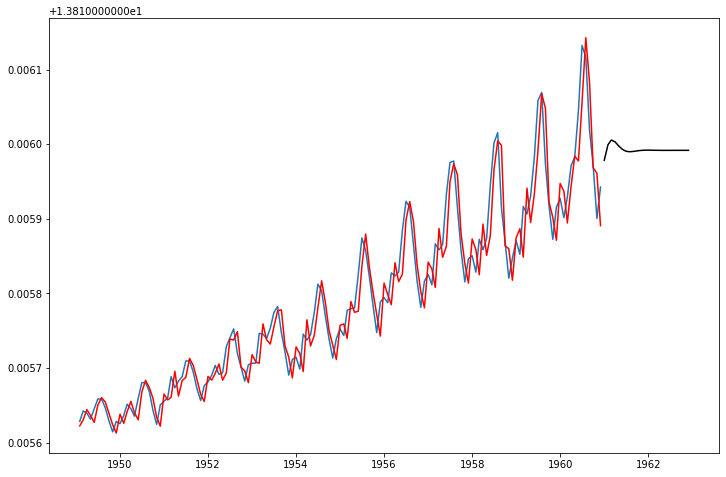

In [45]:
# Call figure() and plot() on the plt
plt.figure(figsize=(12,8))
#plt.plot(y_log.diff())

# CB the prediction is undifferenced, but is 0 for first element.
# CB Need to remove first element from both plots so y axis limits reasonable.
plt.plot(y_log[1:])
plt.plot(model_fit.predict()[1:], color = 'red');
# CB also include a 2 year forecast
plt.plot(forecast, color = 'black');

In [46]:
# https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima.model.ARIMAResults.predict.html
# the red prediction looks offset by one only because that's how the within-sample prediction works:
# n+1 value starts at previous value, +/- some predicted change

### 3f. Application: Forecasting

We've done well: our model fits pretty closely to our existing data. Let's now use it to forecast what's likely to occur in future.

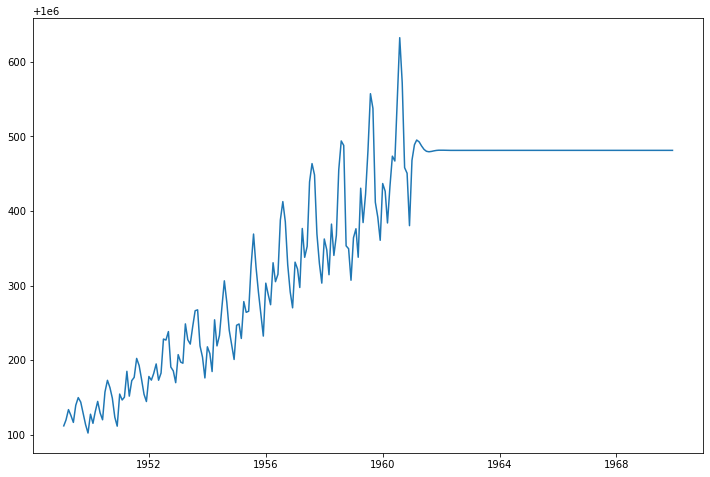

In [48]:
# Declare a variable called forecast_period with the amount of months to forecast, and
# create a range of future dates that is the length of the periods you've chosen to forecast

# CB out-of-sample prediction = forecasting
#https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima.model.ARIMAResults.forecast.html

# CB more general within and out-of-sample prediction
# https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima.model.ARIMAResults.predict.html
#future_prediction = model_fit.predict(start='1961-01-01',end='1969-12-01')
# however, for forecasts to start at a realistic value, .predict() time range needs to include some in-sample range
prediction = np.exp(model_fit.predict(end='1969-12-01'))

# Convert that range into a dataframe that includes your predictions
#_ _ _

# Plot your future predictions
plt.plot(prediction[1:]);

CB how come the forecast doesn't include an upward trend beyond the in-sample range?

DataCamp's New York temperature forecast using ARIMA model does show upward trend. It seems pointless ending up with a model that doesn't even capture trend.

https://campus.datacamp.com/courses/time-series-analysis-in-python/putting-it-all-together-5?ex=9


## 4. Evaluating and Concluding

Our model captures the centre of a line that's increasing at a remarkable rate. Cowboy Cigarettes sell more cigarettes in the summer, perhaps due to the good weather, disposable income and time off that people enjoy, and the least in the winter, when people might be spending less and enjoying less free time outdoors. 

Remarkably, our ARIMA model made predictions using just one variable. We can only speculate, however, on the causes of the behaviour predicted by our model. We should also take heed that spikes in data, due to sudden unusual circumstances like wars, are not handled well by ARIMA; and the outbreak of the Vietnam War in the 1960s would likely cause our model some distress.  

We could suggest to our employers that, if they are interested in discovering the causes of the cigarette sales trajectory, they execute a regression analysis in addition to the time series one. 

In [49]:
# CB: let me try alternate parameters with extra autogression lag that had much lower mean squared error...
# https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima.model.ARIMA.html
# Also, since original forecast didn't trend upward, let's try trend = 'ct' option, which requires d=0
p=10
d=0
q=1
model = ARIMA(y_log, order=(p,d,q),trend='ct')
model_fit = model.fit()
forecast = model_fit.forecast(24)

/Users/Carsten/opt/anaconda3/envs/springboard/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/Carsten/opt/anaconda3/envs/springboard/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/Carsten/opt/anaconda3/envs/springboard/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/Carsten/opt/anaconda3/envs/springboard/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization 

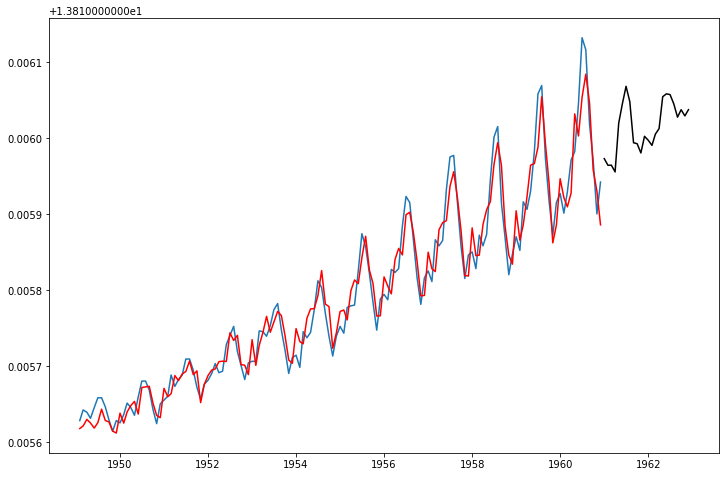

In [50]:
# Call figure() and plot() on the plt
plt.figure(figsize=(12,8))
#plt.plot(y_log.diff())

# CB the prediction is undifferenced, but is 0 for first element.
# CB Need to remove first element from both plots so y axis limits reasonable.
plt.plot(y_log[1:])
plt.plot(model_fit.predict()[1:], color = 'red');
# CB also include a 2 year forecast
plt.plot(forecast, color = 'black');

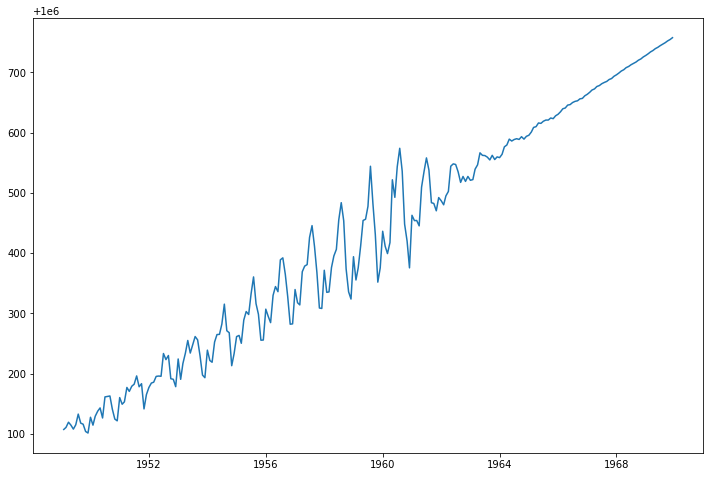

In [51]:
prediction = np.exp(model_fit.predict(end='1969-12-01'))
plt.plot(prediction[1:]);

In [52]:
# CB, OK this is more reasonable.  I also see ability to explicitly add seasonal modeling to ARIMA model

# https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima.model.ARIMA.html
# has seasonal_order input option